# Analyzing word and document frequency: tf-idf

A central question in text mining and natural language processing is how to quantify what a document is about. Can we do this by looking at the words that make up the document? 

One measure of how important a word may be is its term frequency (tf). 

This is how frequently a word occurs in a document - as we saw in Lab 2. However, there are words in a document that occur many times but may not be important. In English these words are most often things like “the”, “is”, “of”, and so forth. We might take the approach of adding words like these to a list of stop words and removing them before analysis, but it is possible that some of these words might be more important in some documents than others. A list of stop words is not a very sophisticated approach to adjusting term frequency for commonly used words.

Another approach is to look at a term’s inverse document frequency (idf), which decreases the weight for commonly used words and increases the weight for words that are not used very much in a collection of documents. This can be combined with term frequency to calculate a term’s tf-idf (the two quantities multiplied together), the frequency of a term adjusted for how rarely it is used.

The tf-idf statistic is intended to measure how important a word is to a document in a collection (or corpus) of documents, for example, to one novel in a collection of novels or to one website in a collection of websites.

### Preparing data

In [72]:
import requests
import string
import pandas as pd

# Jane Eyre
book_url = 'https://www.gutenberg.org/files/1260/1260-0.txt'
response = requests.get(book_url)
bronte1 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte1 = ''.join(c for c in bronte1 if c in allowed_chars)

# Wuthering Heights
book_url = 'https://www.gutenberg.org/cache/epub/768/pg768.txt'
response = requests.get(book_url)
bronte2 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte2 = ''.join(c for c in bronte2 if c in allowed_chars)

# Vilette
book_url = 'https://www.gutenberg.org/files/9182/9182-0.txt'
response = requests.get(book_url)
bronte3 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte3 = ''.join(c for c in bronte3 if c in allowed_chars)

# Agnes Gray
book_url = 'https://www.gutenberg.org/files/767/767-0.txt'
response = requests.get(book_url)
bronte4 = response.text
allowed_chars = string.ascii_letters + string.digits + string.whitespace
bronte4 = ''.join(c for c in bronte4 if c in allowed_chars)

# Create our dataframes
bronte1_lines = bronte1.splitlines()

bronte1_df = pd.DataFrame({
    "line": bronte1_lines,
    "line_number": list(range(len(bronte1_lines)))
})

bronte2_lines = bronte2.splitlines()

bronte2_df = pd.DataFrame({
    "line": bronte2_lines,
    "line_number": list(range(len(bronte2_lines)))
})

bronte3_lines = bronte3.splitlines()

bronte3_df = pd.DataFrame({
    "line": bronte3_lines,
    "line_number": list(range(len(bronte3_lines)))
})

bronte4_lines = bronte4.splitlines()

bronte4_df = pd.DataFrame({
    "line": bronte4_lines,
    "line_number": list(range(len(bronte4_lines)))
})

# We’ll want to know which content comes from which book
bronte1_df = bronte1_df.assign(book = 'Jane Eyre')
bronte2_df = bronte2_df.assign(book = 'Wuthering Heights')
bronte3_df = bronte3_df.assign(book = 'Vilette')
bronte4_df = bronte4_df.assign(book = 'Agnes Grey')

# Finally, we concatenate the books into one dataframe
books = [bronte1_df, bronte2_df, bronte3_df, bronte4_df]
bronte_books_df = pd.concat(books)
bronte_books_df.head()

,line,line_number,book
0,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre
1,,1,Jane Eyre
2,This eBook is for the use of anyone anywhere i...,2,Jane Eyre
3,most other parts of the world at no cost and w...,3,Jane Eyre
4,whatsoever You may copy it give it away or reu...,4,Jane Eyre


In [73]:
# We split the data into words
# We first split the text column into a list of words
bronte_books_df['word'] = bronte_books_df['line'].str.split()

# Explode the words column to create a new row for each word (this creates a separate row for each word from the newly created words list)
bronte_books_df = bronte_books_df.explode('word')

# Reset the index of the dataframe (we want to index each word now)
bronte_books_df = bronte_books_df.reset_index(drop=True)
bronte_books_df.head()

,line,line_number,book,word
0,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,The
1,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,Project
2,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,Gutenberg
3,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,eBook
4,The Project Gutenberg eBook of Jane Eyre by Ch...,0,Jane Eyre,of


In [74]:
# For our investigations the line & line_number columns will not be necessary, so we will remove them
bronte_books_df = bronte_books_df[['book', 'word']]
bronte_books_df

,book,word
0,Jane Eyre,The
1,Jane Eyre,Project
2,Jane Eyre,Gutenberg
3,Jane Eyre,eBook
4,Jane Eyre,of
...,...,...
585196,Agnes Grey,about
585197,Agnes Grey,new
585198,Agnes Grey,eBooks
585199,Agnes Grey,NaN


### Word counting revisited

In [75]:
# Let's count the occurrences of each word - this is a prerequisite for finding term frequency
count_df = bronte_books_df.groupby('word')['word'].count() # Group by word column, then only keep the word column and perform the counting

# Let's sort by term frequency
count_df_sorted = count_df.sort_values(ascending=False)

pd.set_option('display.max_rows', 10) # You can change the max number of rows that get displayed
count_df_sorted.head(10)

word
the    22423
and    19617
I      18439
to     15784
of     13370
a      12297
in      8104
was     7444
you     6431
her     5981
Name: word, dtype: int64

In [76]:
# The .size() method functions similary, but differs slightly in output format
# .size() also counts null values, which .count() does not
bronte_books_df.groupby(['word']).size().sort_values(ascending=False).reset_index(name='count')

,word,count
0,the,22423
1,and,19617
2,I,18439
3,to,15784
4,of,13370
...,...,...
30118,glovessuch,1
30119,gloveless,1
30120,glossily,1
30121,glossiest,1


In [77]:
# Groupby allows grouping based on multiple columns
bronte_books_df.groupby(['word', 'book']).size().sort_values(ascending=False).reset_index(name='count')

,word,book,count
0,the,Vilette,7894
1,the,Jane Eyre,7501
2,I,Jane Eyre,7009
3,and,Jane Eyre,6328
4,and,Vilette,6163
...,...,...,...
54094,gild,Vilette,1
54095,gilt,Jane Eyre,1
54096,gilt,Vilette,1
54097,gin,Agnes Grey,1


### Aggregate
One useful and elegant way of counting/aggregating data in pandas is by using the .agg() method.


In [78]:
# We group our data by words, then we aggregate and can decide what information we want to display for each column

# setting 'first' for the book column means that in the new dataframe we will display the first book on which each word occurs (in the book column)
# setting 'count' for the word column means that in the new dataframe we will display the count of given word (in the word column)
count_df = bronte_books_df.groupby('word').agg({'book': 'first', 'word': 'count'}) 
count_df

,book,word
word,,
1,Jane Eyre,9
10,Vilette,1
12,Vilette,1
1260,Jane Eyre,1
13th,Jane Eyre,1
...,...,...
zigzag,Jane Eyre,2
zigzags,Vilette,1
zle,Vilette,1


In [79]:
# Because we used groupby, the 'word' keyword has become both an index and a column name
# To get rid of any naming problems down the line, we will rename the column name 'word' to 'count'
count_df = count_df.rename(columns={'word': 'count'})

# Sorting values based on count column
count_df.sort_values('count', ascending=False)

,book,count
word,,
the,Jane Eyre,22423
and,Jane Eyre,19617
I,Jane Eyre,18439
to,Jane Eyre,15784
of,Jane Eyre,13370
...,...,...
glovessuch,Vilette,1
gloveless,Agnes Grey,1
glossily,Jane Eyre,1


### Merging Dataframes

What we want next is to have a dataframe in which we know how many times each word appears per book and how many times it appears in all of the books.

It is sometimes very useful to merge together two dataframes and this is what we're going to do to get our desired dataframe.

In [80]:
count_df_1 = bronte_books_df.groupby(['word', 'book']).size().sort_values(ascending=False).reset_index(name='count') # How many appearances each word has in each book
count_df_1

,word,book,count
0,the,Vilette,7894
1,the,Jane Eyre,7501
2,I,Jane Eyre,7009
3,and,Jane Eyre,6328
4,and,Vilette,6163
...,...,...,...
54094,gild,Vilette,1
54095,gilt,Jane Eyre,1
54096,gilt,Vilette,1
54097,gin,Agnes Grey,1


In [81]:
count_df_2 = bronte_books_df.groupby(['book']).size().sort_values(ascending=False).reset_index(name='count') # How many words each book has
count_df_2

,book,count
0,Vilette,199315
1,Jane Eyre,192766
2,Wuthering Heights,121112
3,Agnes Grey,72008


In [82]:
book_words = count_df_1.merge(count_df_2, on='book')
book_words.head(10)

,word,book,count_x,count_y
0,the,Vilette,7894,199315
1,and,Vilette,6163,199315
2,I,Vilette,5762,199315
3,of,Vilette,4924,199315
4,to,Vilette,4732,199315
5,a,Vilette,4406,199315
6,in,Vilette,2980,199315
7,was,Vilette,2836,199315
8,her,Vilette,2071,199315
9,it,Vilette,1905,199315


In [83]:
book_words = book_words.rename(columns={'count_x': 'word_appearances_in_book', 'count_y': 'book_total_word_count'}) # Give more meaningful names
book_words.head(10)

,word,book,word_appearances_in_book,book_total_word_count
0,the,Vilette,7894,199315
1,and,Vilette,6163,199315
2,I,Vilette,5762,199315
3,of,Vilette,4924,199315
4,to,Vilette,4732,199315
5,a,Vilette,4406,199315
6,in,Vilette,2980,199315
7,was,Vilette,2836,199315
8,her,Vilette,2071,199315
9,it,Vilette,1905,199315


### Exercise 1 

1. Add a **tf** (term frequency) column to your dataframe.
2. Add a **rank** column to your dataframe.
3. Draw the rank vs term-frequency plot by uncommenting the code below 

Term frequency says how frequently a given word appears in a book. The formula for calculating it is 
    
    term_frequency = word_appearances_in_book / book_total_word_count

E.g. If a word appears 30 times in a book with 1000 words, then the term frequency of that word will be 0.03. (or 3%).

The rank of a word will tell you where your word places itself in the frequency rankings **of your book**.

i.e. The most common word in your book will have rank 1.
E.g. If the entire text of your book is: "he ate chips, ate pudding and he ate spinach", then you would have:

    ate - rank 1 (count = 3)
    he - rank 2 (count = 2)
    chips - rank 3 (count = 1)
    pudding - rank 3 (count = 1)
    and - rank 3 (count = 1)
    spinach - rank 3 (count = 1)


Hint: you can use the pandas .rank(method='dense', ascending=False) method for obtaining your word rank. 

In [84]:
# Write your code below
book_words['tf'] = book_words['word_appearances_in_book'] / book_words['book_total_word_count']
book_words['rank'] = book_words.groupby('book')['word_appearances_in_book'].rank(method='dense', ascending=False)
book_words

,word,book,word_appearances_in_book,book_total_word_count,tf,rank
0,the,Vilette,7894,199315,0.039606,1.0
1,and,Vilette,6163,199315,0.030921,2.0
2,I,Vilette,5762,199315,0.028909,3.0
3,of,Vilette,4924,199315,0.024705,4.0
4,to,Vilette,4732,199315,0.023741,5.0
...,...,...,...,...,...,...
54094,ghost,Agnes Grey,1,72008,0.000014,164.0
54095,gesticulating,Agnes Grey,1,72008,0.000014,164.0
54096,girded,Agnes Grey,1,72008,0.000014,164.0
54097,gifts,Agnes Grey,1,72008,0.000014,164.0


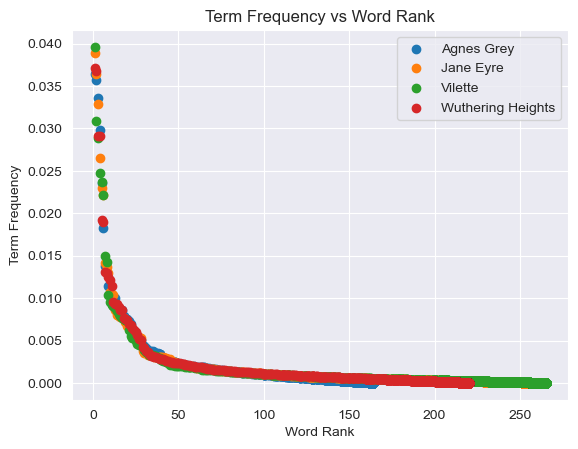

In [85]:
# Write your code below

#Uncomment below for Ex. 1.3.
import matplotlib.pyplot as plt

# plot the data
for book, data in book_words.groupby("book"):
    plt.scatter(data["rank"], data["tf"], label=book)

# add labels and legend
plt.title("Term Frequency vs Word Rank")
plt.xlabel("Word Rank")
plt.ylabel("Term Frequency")
plt.legend()

### Excercise 2 - TF-IDF

1. Add a new idf column to your dataframe
2. Add the final tf-idf column to your dataframe
3. Display your dataframe's words in descending order of their tf-idf.

Idf or inverse document frequency is computed as **idf = log(N / n)**

where **N is the total number of documents (books)** in your dataset and **n is the number of documents containing the word**.

Once you have tf and idf, the tf-idf is obtained by simply multiplying the two.

Hint: For ex. 2.1 the pandas **transform** function could come in handy.

In [86]:
# Write your code below
import numpy as np

total_books = len(book_words['book'].unique())  # Total number of documents (books)
book_words['idf'] = np.log(total_books / book_words.groupby('word')['book'].transform('nunique'))

book_words['tf_idf'] = book_words['tf'] * book_words['idf']

sorted_df = book_words.sort_values(by='tf_idf', ascending=False)
print(sorted_df.head(10))

             word               book  word_appearances_in_book  \
34975  Heathcliff  Wuthering Heights                       413   
34983      Linton  Wuthering Heights                       340   
18926   Rochester          Jane Eyre                       312   
34984   Catherine  Wuthering Heights                       333   
35029     Hareton  Wuthering Heights                       164   
46063      Murray         Agnes Grey                        82   
95             Dr            Vilette                       225   
102       Bretton            Vilette                       216   
110        Graham            Vilette                       198   
46074      Weston         Agnes Grey                        69   

       book_total_word_count        tf   rank       idf    tf_idf  
34975                 121112  0.003410   33.0  1.386294  0.004727  
34983                 121112  0.002807   41.0  1.386294  0.003892  
18926                 192766  0.001619   71.0  1.386294  0.002244  
3

# Language Models

A language model is a statistical model that can be used to estimate the probability of a sequence of words in a language. It is trained on a corpus of text data, and learns to predict the likelihood of observing a given sequence of words based on the frequency and context of those words in the training data.

Language models can be used for a variety of natural language processing tasks, such as text generation, machine translation, speech recognition, and more.

In [87]:
import nltk
from nltk.corpus import brown
from nltk import FreqDist
nltk.download('brown')

# load the Brown corpus
corpus = brown.words()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In this example, we're using the Brown corpus from the nltk library, which is a collection of text samples from a wide range of genres, including news, fiction, and academic writing.

In [88]:
print(corpus[1100:1110]) # Print a sample of 10 words from the corpus

['voters', '.', 'Despite', 'the', 'warning', ',', 'there', 'was', 'a', 'unanimous']


In [89]:
# create a frequency distribution of the words in the corpus
freq_dist = FreqDist(corpus)

# calculate the total number of words in the corpus
total_words = len(corpus)

# calculate the probability of each word in the corpus
word_probs = {word: freq_dist[word] / total_words for word in freq_dist.keys()}
print(word_probs['high']) # Probability of the word 'high' to appear

0.0003970058353829513


### Naive sentence generation

We're going to create a naive function that generates sentences using our language model.

In [90]:
# generate a sentence using the language model
import random

def generate_sentence(word_length = 10):
    sentence = []
    while len(sentence) < word_length:
        word = random.choices(list(word_probs.keys()), list(word_probs.values()))[0]
        sentence.append(word)
    return " ".join(sentence)

In [91]:
print(generate_sentence())

a we living model It had bunched comment 1959 a


The sentences generated are likely not going to sound very good, since the model is extremely naive.

All that is happening is that each word in the sentence gets semi-randomly generated with the likelihood of it being chosen depending on its frequency in the Brown corpus.

# N-grams

So far we’ve considered words as individual units, and considered the relationship to their frequency of occurrence. However, many interesting text analyses are based on the relationships between words.
One such relationship is given by n-grams.

N-grams are groups of n consecutive words that appear in a given text corpus.

Bigrams are groups of 2 consecutive words (e.g. she went, he ate, car crashed)

Trigrams are groups of 3 consecutive words (e.g. she went home, he ate a, the car crashed).

In [92]:
# Example of what bigrams look like
bigrams = list(nltk.bigrams(corpus))
bigrams[:10]

[('The', 'Fulton'),
 ('Fulton', 'County'),
 ('County', 'Grand'),
 ('Grand', 'Jury'),
 ('Jury', 'said'),
 ('said', 'Friday'),
 ('Friday', 'an'),
 ('an', 'investigation'),
 ('investigation', 'of'),
 ('of', "Atlanta's")]

In [93]:
# Example of what trigrams look like
trigrams = list(nltk.trigrams(corpus))
trigrams[:10]

[('The', 'Fulton', 'County'),
 ('Fulton', 'County', 'Grand'),
 ('County', 'Grand', 'Jury'),
 ('Grand', 'Jury', 'said'),
 ('Jury', 'said', 'Friday'),
 ('said', 'Friday', 'an'),
 ('Friday', 'an', 'investigation'),
 ('an', 'investigation', 'of'),
 ('investigation', 'of', "Atlanta's"),
 ('of', "Atlanta's", 'recent')]

### Naive next word prediction

Knowing that word relations are pretty important in our language, let's create a function that predicts what the next word in a sentence would be using a simple **bigram** language model. 

In [94]:
from nltk.corpus import brown
import random

# get the words from the Brown corpus
corpus = brown.words()

# create bigrams from the corpus
bigrams = list(nltk.bigrams(corpus))

# calculate the frequency distribution of the bigrams
bigram_freqdist = nltk.FreqDist(bigrams)

# calculate the total number of bigrams in the corpus
total_bigrams = len(bigrams)

# create a function to generate the next word based on the previous word
def generate_next_word(sentence):
    prev_word = sentence.split()[-1]
    possible_words = {}
    for bigram in bigram_freqdist:
        if bigram[0] == prev_word:
            possible_words[bigram[1]] = bigram_freqdist[bigram] / total_bigrams
    if possible_words:
        return max(possible_words, key=possible_words.get)
    else:
        return None

In [95]:
# predict the next word for a given context
context = "The director"
next_word = generate_next_word(context)
print(f"The predicted next word for '{context}' is '{next_word}'")

The predicted next word for 'The director' is 'of'


### Exercise 3
1. Create a function that takes as input the number of words and generates a sentence using the previous bigram language model. You can start with a random first word from the brown corpus and then use generate_next_word(sentence) function to help you. 

2. Create a function that predicts the next word of a sentence by looking at the previous two words. This means you will create a trigram language model - use the same Brown corpus as before.

In [96]:
def generate_sentence_bigram(num_words):
    sentence = []
    # Start with a random first word from the corpus
    first_word = random.choice(corpus)
    sentence.append(first_word)
    while len(sentence) < num_words:
        next_word = generate_next_word(" ".join(sentence))
        if next_word:
            sentence.append(next_word)
        else:
            break
    return " ".join(sentence)

corpus = brown.words()

# create bigrams from the corpus
trigrams = list(nltk.trigrams(corpus))

# calculate the frequency distribution of the bigrams
trigram_freqdist = nltk.FreqDist(trigrams)

# calculate the total number of bigrams in the corpus
total_trigrams = len(trigrams)

def generate_next_word_trigram(sentence):
    words = sentence.split()
    prev_word1 = words[-2]
    prev_word2 = words[-1]
    possible_words = {}
    for trigram in trigrams:
        if trigram[0] == prev_word1 and trigram[1] == prev_word2:
            possible_words[trigram[2]] = trigram_freqdist[trigram] / total_trigrams
    if possible_words:
        return max(possible_words, key=possible_words.get)
    else:
        return None

# Example of generating a sentence using the bigram language model
print(generate_sentence_bigram(10))

# Example of predicting the next word using the trigram language model
context = "The director"
next_word = generate_next_word_trigram(context)
print(f"The predicted next word for '{context}' is '{next_word}'")


But the same time , and the same time ,
The predicted next word for 'The director' is 'of'


### N-grams in dataframes

Let's get back to our books.
We'll create a dataframe containing information about the bigrams in our books corpus.


In [97]:
# The simplest way to do this would be to create the dataframe directly from bigrams rather than unigrams (single words)
import nltk
nltk.download('punkt')

bronte1_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte1)))
bronte1_df = pd.DataFrame(bronte1_bigrams, columns=['Word 1', 'Word 2'])

bronte2_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte2)))
bronte2_df = pd.DataFrame(bronte2_bigrams, columns=['Word 1', 'Word 2'])

bronte3_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte3)))
bronte3_df = pd.DataFrame(bronte3_bigrams, columns=['Word 1', 'Word 2'])

bronte4_bigrams = list(nltk.bigrams(nltk.word_tokenize(bronte4)))
bronte4_df = pd.DataFrame(bronte4_bigrams, columns=['Word 1', 'Word 2'])


# We’ll want to know which content comes from which book
bronte1_df = bronte1_df.assign(book = 'Jane Eyre')
bronte2_df = bronte2_df.assign(book = 'Wuthering Heights')
bronte3_df = bronte3_df.assign(book = 'Vilette')
bronte4_df = bronte4_df.assign(book = 'Agnes Grey')

# Finally, we concatenate the books into one dataframe
books = [bronte1_df, bronte2_df, bronte3_df, bronte4_df]
bronte_books_df = pd.concat(books)
bronte_books_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Word 1,Word 2,book
0,The,Project,Jane Eyre
1,Project,Gutenberg,Jane Eyre
2,Gutenberg,eBook,Jane Eyre
3,eBook,of,Jane Eyre
4,of,Jane,Jane Eyre


### Exercise 4

1. Add a **bigram** column that shows the entire bigrams ("The Project" and "Project Gutenberg" are examples of this column's values), not just the separate words.
2. Clean the dataframe by removing stop words.
3. Display the most frequently occuring 10 bigrams.

In [98]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
bronte_books_df['Word 1'] = bronte_books_df['Word 1'].str.lower()
bronte_books_df['Word 2'] = bronte_books_df['Word 2'].str.lower()

bronte_books_df_filtered = bronte_books_df[~bronte_books_df['Word 1'].isin(stop_words) & ~bronte_books_df['Word 2'].isin(stop_words)]

bronte_books_df_filtered['Bigram'] = bronte_books_df_filtered['Word 1'] + ' ' + bronte_books_df_filtered['Word 2']

top_10_bigrams = bronte_books_df_filtered['Bigram'].value_counts().head(10)
print(top_10_bigrams)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Bigram
project gutenberg    292
mr rochester         281
dr john              128
st john              120
mr heathcliff        118
mrs fairfax          107
madame beck          103
mrs bretton           92
young lady            75
miss grey             71
Name: count, dtype: int64


C:\Users\Lucas\AppData\Local\Temp\ipykernel_11240\3887470444.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bronte_books_df_filtered['Bigram'] = bronte_books_df_filtered['Word 1'] + ' ' + bronte_books_df_filtered['Word 2']


### Exercise 5

1. Create a dataframe containing the **bigram, word1, word2** and **book** columns for the following 4 books and remove stop words:
        https://www.gutenberg.org/cache/epub/1228/pg1228.txt - On the Origin of Species, by Charles Darwin

        https://www.gutenberg.org/cache/epub/4363/pg4363.txt - Beyond Good and Evil, by Friedrich Nietzsche

        https://www.gutenberg.org/cache/epub/3296/pg3296.txt - The Confessions of Saint Augustine, by Saint Augustine

        https://www.gutenberg.org/files/1661/1661-0.txt - The Adventures of Sherlock Holmes, by Arthur Conan Doyle

2. Display the most frequent 8 words of each book (use word1 column when counting)

3. Display the most relevant 8 words of each book based on tf-idf (use word1 column when counting)

4. Display the most relevant 5 bigrams of each book based on tf-idf

5. Display the most frequent 5 street names found in the entire 4 book corpus. The book they are coming from should also be visible.

6. Choose a fixed word1 of your choice and find the most common 5 bigrams in each book that have word1 equal to the word you chose.




In [127]:
# Write your code below
import requests
import string
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

book_urls = [
    'https://www.gutenberg.org/cache/epub/1228/pg1228.txt',  # On the Origin of Species, by Charles Darwin
    'https://www.gutenberg.org/cache/epub/4363/pg4363.txt', # Beyond Good and Evil, by Friedrich Nietzsche
    'https://www.gutenberg.org/cache/epub/3296/pg3296.txt', # The Confessions of Saint Augustine, by Saint Augustine
    'https://www.gutenberg.org/files/1661/1661-0.txt'        # The Adventures of Sherlock Holmes, by Arthur Conan Doyle
]

books = []
allowed_chars = string.ascii_letters + string.digits + string.whitespace

for url in book_urls:
    response = requests.get(url)
    text = response.text
    text = ''.join(c for c in text if c in allowed_chars)
    books.append(text)

book_dfs = []

book_dict={
    1: "On the Origin of Species",
    2: "Beyond Good and Evil",
    3: "The Confessions of Saint Augustine",
    4: "The Adventures of Sherlock Holmes"
}

for idx, book_text in enumerate(books, start=1):
    book_bigrams = list(nltk.bigrams(word_tokenize(book_text)))
    book_df = pd.DataFrame(book_bigrams, columns=['Word 1', 'Word 2'])
    book_df['Book'] = book_dict[idx]
    book_dfs.append(book_df)

all_books_df = pd.concat(book_dfs, ignore_index=True)

stop_words = set(stopwords.words('english'))
all_books_df_cleaned = all_books_df[~all_books_df['Word 1'].isin(stop_words) & ~all_books_df['Word 2'].isin(stop_words)]

top_8_words_per_book = all_books_df_cleaned.groupby('Book')['Word 1'].value_counts().groupby('Book').head(8)
print("Most frequent 8 words of each book:")
print(top_8_words_per_book)

all_books_df['tf'] = all_books_df.groupby(['Book', 'Word 1'])['Word 1'].transform('count') / all_books_df.groupby('Book')['Word 1'].transform('count')
total_books = len(all_books_df['Book'].unique())
all_books_df['idf'] = np.log(total_books / all_books_df.groupby('Word 1')['Book'].transform('nunique'))
all_books_df['tf_idf'] = all_books_df['tf'] * all_books_df['idf']
sorted_df = all_books_df.sort_values(by='tf_idf', ascending=False).drop_duplicates("Word 1")
for book, group in sorted_df.groupby('Book'):
    print(f"Book {book}:")
    for idx, row in group.head(8).iterrows():
        print(f"{row['Word 1']}: {row['tf_idf']}")
    print()


bigram_tfidf_per_book = all_books_df.groupby(['Book', 'Word 1', 'Word 2'])['tf_idf'].sum().reset_index()

# Sort the DataFrame by tf-idf values in descending order
sorted_bigram_tfidf = bigram_tfidf_per_book.sort_values(by='tf_idf', ascending=False)

# Display the most relevant 5 bigrams of each book based on tf-idf
for book, group in sorted_bigram_tfidf.groupby('Book'):
    print(f"Book {book}:")
    for idx, row in group.head(5).iterrows():
        print(f"{row['Word 1']} {row['Word 2']}: {row['tf_idf']}")
    print()

# Extract street names from the entire corpus
street_names = ['Baker', 'Street', 'Park', 'Avenue', 'Lane']  # Example street names
street_names_df = all_books_df_cleaned[all_books_df_cleaned['Word 1'].isin(street_names)]
most_frequent_street_names = street_names_df['Word 1'].value_counts().head(5)
print("\nMost frequent 5 street names found in the entire 4 book corpus:")
print(most_frequent_street_names)


# Choose a fixed word1 and find the most common 5 bigrams in each book that have word1 equal to the chosen word
fixed_word1 = 'origin'  # Example fixed word1
most_common_bigrams_with_word1 = all_books_df_cleaned[all_books_df_cleaned['Word 1'] == fixed_word1]['Word 2'].value_counts().head(5)
print(f"\nMost common 5 bigrams in each book with 'Word 1' equal to '{fixed_word1}':")
print(most_common_bigrams_with_word1)

Most frequent 8 words of each book:
Book                                Word 1 
Beyond Good and Evil                one        199
                                    The        190
                                    I          132
                                    every      120
                                    Project     85
                                              ... 
The Confessions of Saint Augustine  Thee       347
                                    yet        225
                                    God        223
                                    O          218
                                    things     216
Name: count, Length: 32, dtype: int64
Book Beyond Good and Evil:
morality: 0.00149700983497106
philosopher: 0.0010964015692745792
nowadays: 0.0007801318858299891
refined: 0.0006114547213262076
morals: 0.000590370075763235
German: 0.00037628949840838875
skepticism: 0.00033735432900756283
distrust: 0.00033735432900756283

Book On the Origin of Species:
specie